In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten,experimental,Conv2D,LeakyReLU,BatchNormalization,Activation,MaxPooling2D
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras import optimizers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
%load_ext tensorboard

# Helper libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import datetime
import cv2

In [3]:
 #Install subversion to use svn
!apt-get install subversion

#!svn checkout specific folder
!svn checkout https://github.com/dphi-official/Datasets.git/trunk/animal_data

 #unzipping the train contents
!unzip animal_data/train_beg.zip

#unzipping the test contents
!unzip animal_data/test_beg.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd6

**Task - 1 DATA LOADING**

In [4]:
#function to load images as grayscale
import cv2
def read_images_bw(filepaths,resize):
  temp = []
  for filename in filepaths: 
    im = cv2.imread(filename)
    im = im.astype(float)
    im_converted = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    new_image = cv2.resize(im_converted, (0,0), fx=resize, fy=resize,interpolation = cv2.INTER_CUBIC) 
    temp.append(new_image)
  return(temp)


#function to load images
import cv2
def read_images(filepaths,resize):
  temp = []
  for filename in filepaths: 
    im = cv2.imread(filename)
    im = im.astype(float)
    new_image = cv2.resize(im, (0,0), fx=resize, fy=resize,interpolation = cv2.INTER_CUBIC ) 
    temp.append(new_image)
  return(temp) 

Load training set

In [5]:
# accessing the training_set_labels
training_set = pd.read_csv('animal_data/Training_set_animals.csv')
training_set.head()   # this file contains file name and corresponding labels

#convert the categories to 0 and 1
animal_classes = ['mucca','pecora']
training_labels =np.array([0 if animal == "mucca" else 1 for animal in training_set.animal_type])

# getting the path of all image files
train_filepaths = ['/content/train_beg/' + fname[:-4] + '.jpg' for fname in training_set['filename']]

# Confirm if number of images is same as number of labels given
if len(training_set) == len(train_filepaths):
    training_set["filepaths"] = train_filepaths
    print('Number of labels i.e. ', len(training_set), 'matches the number of filenames i.e. ', len(train_filepaths))
else:
    print('Number of labels does not match the number of filenames')

#load trainning images
train_images = np.array(read_images(training_set.filepaths,1))
train_images.shape


img_height = train_images[0].shape[0]
img_width = train_images[0].shape[1]

Number of labels i.e.  1200 matches the number of filenames i.e.  1200


Load testing data

In [6]:
#read the test set
temp = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/animal_data/Testing_set_animals.csv")
temp.head()

#We find a small issue with the test data, an image file is present as the column name, we need to fix that
testing_set = pd.DataFrame(temp.columns)
testing_set=testing_set.append(pd.DataFrame(temp[:].values),ignore_index=True)
testing_set.columns = ["filename"]

#test image filepaths
test_filepaths = ['/content/test_beg/' + fname[:-4] + '.jpg' for fname in testing_set['filename']]
testing_set["filepaths"] = test_filepaths

test_images = np.array(read_images(testing_set.filepaths,1))

In [7]:
def view_images(dat,label,numbers,seed):
  plt.figure(figsize=(15,15))
  random.seed(seed)
  index = [random.randint(1,len(dat)) for i in range(0,numbers)]
  for i in range(numbers):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])    
    plt.imshow(dat[index[i]].reshape(img_height,img_width), cmap='gray')
    plt.xlabel(label[index[i]])

**Task - 2 Preprocessing**


*   The image size can be increased using the function read_images
*   Functions to load them as grayscale or colour image is also present. 
*   Data augmentation can be done to increase the training data size if needed






In [8]:
#to carry out data augumentation, we need to add channel data for grayscale images
# reshape to be [samples][width][height][channels]
#train_images = train_images.reshape((train_images.shape[0], img_height, img_width, 1))
#test_images = test_images.reshape((test_images.shape[0], img_height, img_width, 1))

In [9]:
from sklearn.model_selection import train_test_split
#split the data into test and train data sets
x_train, x_test, y_train, y_test = train_test_split(train_images, training_labels, test_size=0.3, random_state=1)
# find the number of input features
x_train.shape

(840, 200, 300, 3)

In [10]:
#data augmentation layer, if required
data_augmentation = tf.keras.Sequential([
  experimental.preprocessing.RandomFlip("horizontal_and_vertical",input_shape=(400,600,1)),
  experimental.preprocessing.RandomRotation(factor=(-0.2, 0.3)),
  #experimental.preprocessing.RandomZoom(height_factor=0.2,width_factor=0.3),
  experimental.preprocessing.RandomContrast(factor=(0,0.5)),
  experimental.preprocessing.RandomTranslation(width_factor=0.2,height_factor=0.3)])

**TASK 7 Optimization Techniques**

*   Transfer Learning
*   Drop out layers added : Increasing the drop out ratio improved the validation accuracy
*   Tried out L1 and L2 regularization, L2 regularization showed better results. 




---



In [11]:
#Resnet50 model
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height,img_width,3))
#remove the output layer
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, outputs = output)
#do not train the layers
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

94773248/94765736 [==============================] - 4s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 150, 64) 256         conv1_conv[0][0]                 
______________________

**TASK 3: Building a Multi-Layer Perceptron**

In [12]:
input_shape = train_images[0].shape
model = Sequential()
#commented because it did not bring any signigicant improvement to the model. 
#model.add(data_augmentation)
model.add(restnet)
model.add(Dense(512, activation='relu', input_dim=input_shape,kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu',kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))



**TASK 4: Optimizer**

In [14]:

#early stopping is used to optimize the training, it automatically stops training when the monitor metrics does not improve
earlystopping_callback = EarlyStopping(
   monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
   baseline=None, restore_best_weights=True
)



#binary_crossentropy is used since we need binary classification
#accuracy as metrics since this is a classification problem
#adam for optimizer function as it automatically adjusts the learning rate
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 143360)            23587712  
_________________________________________________________________
dense (Dense)                (None, 512)               73400832  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 97,251,713
Trainable params: 73,664,001
Non-trainable params: 23,587,712
_________________________________

**TASK 6: Tensorboard**

In [15]:
path = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1)

**Task 5 - Training the model**

Epoch 1/20
1/7 [===>..........................] - ETA: 0s - loss: 16.3926 - accuracy: 0.4766WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
7/7 [==============================] - 27s 4s/step - loss: 37.5057 - accuracy: 0.6107 - val_loss: 19.1171 - val_accuracy: 0.8333
Epoch 2/20
7/7 [==============================] - 19s 3s/step - loss: 20.7499 - accuracy: 0.8512 - val_loss: 20.2089 - val_accuracy: 0.8694
Epoch 3/20
7/7 [==============================] - 19s 3s/step - loss: 18.0242 - accuracy: 0.9214 - val_loss: 17.1621 - val_accuracy: 0.9194
Epoch 4/20
7/7 [==============================] - 19s 3s/step - loss: 15.5815 - accuracy: 0.9667 - val_loss: 15.5434 - val_accuracy: 0.9333
Epoch 5/20
7/7 [==============================] - 19s 3s/step - loss: 13.4760 - a

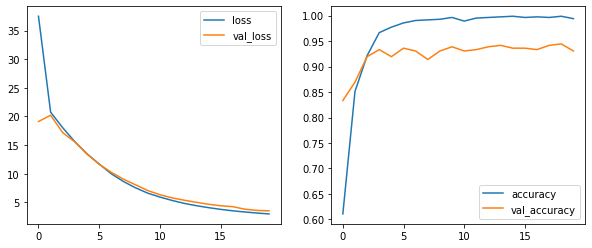

In [16]:
history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    epochs=20,
                    verbose=1,
                    callbacks=[earlystopping_callback,tensorboard_callback]
                    )



fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
%tensorboard --logdir logs/fit

**TASK 8: Predict**

In [17]:
predictions = model.predict(test_images)
predictions = ([int(np.round(x)) for x in predictions])
res = []
for prediction in predictions:
  res.append(animal_classes[prediction])


res = pd.DataFrame(res) #preditcions are nothing but the final predictions of your model on input features of your new unseen test data
res.index = pd.DataFrame(test_filepaths).index # its important for comparison. Here "test_new" is your new test dataset
res.columns = ["prediction"]

# To download the csv file locally
from google.colab import files
res.to_csv('prediction_results.csv')         
files.download('prediction_results.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**TPU implementation**

In [ ]:
import os
import pprint
import tensorflow as tf
import os


use_tpu = True #@param {type:"boolean"}

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''





# TPU address
tpu_address = TF_MASTER
import tensorflow as tf

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
# use TPUStrategy scope to define model
with strategy.scope():
  #Resnet50 model
  restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height,img_width,3))
  #remove the output layer
  output = restnet.layers[-1].output
  output = keras.layers.Flatten()(output)
  restnet = Model(restnet.input, outputs = output)
  #do not train the layers
  for layer in restnet.layers:
      layer.trainable = False
  restnet.summary()
  input_shape = train_images[0].shape
  model = Sequential()
  model.add(restnet)
  model.add(Dense(512, activation='relu', input_dim=input_shape,kernel_regularizer='l2'))
  model.add(Dropout(0.3))
  model.add(Dense(512, activation='relu',kernel_regularizer='l2'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  
  #early stopping is used to optimize the training, it automatically stops training when the monitor metrics does not improve
  earlystopping_callback = EarlyStopping(
   monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
   baseline=None, restore_best_weights=True)
#binary_crossentropy is used since we need binary classification
#accuracy as metrics since this is a classification problem
#adam for optimizer function as it automatically adjusts the learning rate
  model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.00001),
              metrics=['accuracy'])
model.summary()


INFO:tensorflow:Initializing the TPU system: grpc://10.40.216.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.40.216.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 200, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 306, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 150, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

Epoch 1/50
2/7 [=======>......................] - ETA: 0s - loss: 16.2380 - accuracy: 0.5586WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0071s vs `on_train_batch_end` time: 0.0688s). Check your callbacks.


7/7 [==============================] - ETA: 0s - loss: 15.9905 - accuracy: 0.6631WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0040s vs `on_test_batch_end` time: 0.0396s). Check your callbacks.


7/7 [==============================] - 26s 4s/step - loss: 15.9905 - accuracy: 0.6631 - val_loss: 15.4786 - val_accuracy: 0.9194
Epoch 2/50
7/7 [==============================] - 3s 419ms/step - loss: 15.4285 - accuracy: 0.9250 - val_loss: 15.3723 - val_accuracy: 0.9306
Epoch 3/50
7/7 [==============================] - 3s 416ms/step - loss: 15.2754 - accuracy: 0.9631 - val_loss: 15.2823 - val_accuracy: 0.9417
Epoch 4/50
7/7 [==============================] - 3s 408ms/step - loss: 15.1675 - accuracy: 0.9810 - val_loss: 15.2007 - val_accuracy: 0.9389
Epoch 5/50
7/7 [==============================] - 3s 423ms/step - loss: 15.0745 - accuracy: 0.9905 - val_loss: 15.1229 - val_accuracy: 0.9389
Epoch 6/50
7/7 [==============================] - 3s 411ms/step - loss: 14.9794 - accuracy: 0.9940 - val_loss: 15.0430 - val_accuracy: 0.9389
Epoch 7/50
7/7 [==============================] - 3s 421ms/step - loss: 14.8938 - accuracy: 0.9988 - val_loss: 14.9642 - val_accuracy: 0.9389
Epoch 8/50
7/7 [===

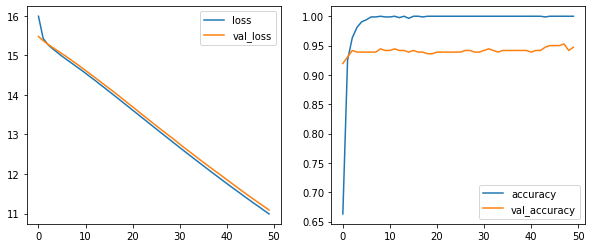

In [ ]:
history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    epochs=50,
                    verbose=1,
                    callbacks=[earlystopping_callback]
                    )



fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);